In [ ]:
!pip install torch torchvision matplotlib


100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s]


Epoch [1/10] D Loss: 1.0992, G Loss: 0.5678
Epoch [2/10] D Loss: 0.5060, G Loss: 2.7113
Epoch [3/10] D Loss: 1.2431, G Loss: 3.9827
Epoch [4/10] D Loss: 0.4229, G Loss: 2.2684
Epoch [5/10] D Loss: 1.1486, G Loss: 8.1007
Epoch [6/10] D Loss: 1.0081, G Loss: 6.7625
Epoch [7/10] D Loss: 0.0252, G Loss: 4.5718
Epoch [8/10] D Loss: 0.0043, G Loss: 6.3371
Epoch [9/10] D Loss: 0.1380, G Loss: 4.7357
Epoch [10/10] D Loss: 2.3294, G Loss: 14.0363


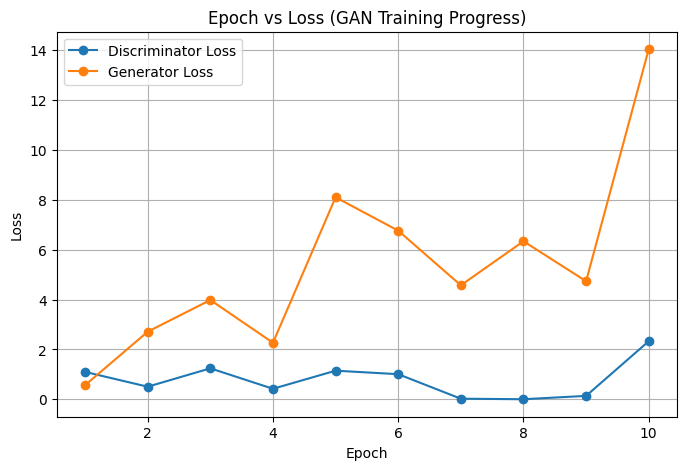

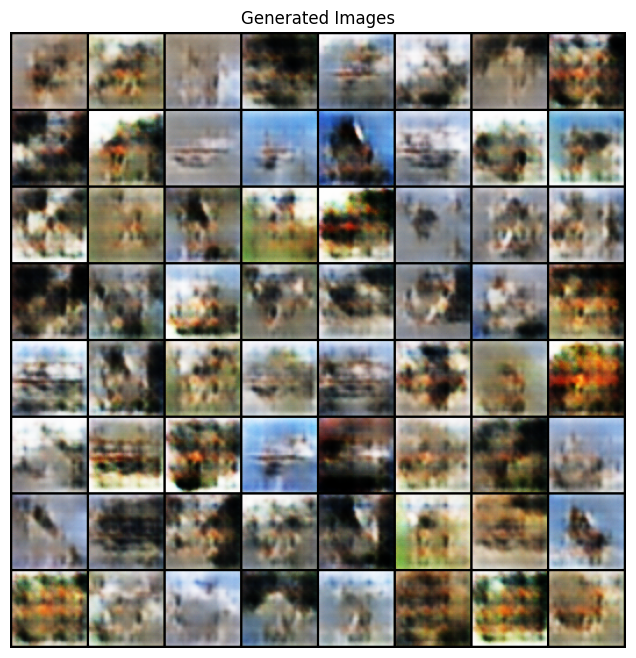

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# 1. Hyperparameters
batch_size = 128
latent_dim = 100
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Data loading (CIFAR-10 color images)
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)

# 4. Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x).view(-1, 1)

# 5. Initialize models
netG, netD = Generator().to(device), Discriminator().to(device)
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Lists to store losses
d_losses = []
g_losses = []

# 6. Training loop
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Real labels = 1, Fake labels = 0
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = netG(z)
        real_loss = criterion(netD(real_imgs), real_labels)
        fake_loss = criterion(netD(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizerD.zero_grad()
        d_loss.backward()
        optimizerD.step()

        # Train Generator
        g_loss = criterion(netD(fake_imgs), real_labels)
        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()

    # Store losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# 7. Plot Epoch Graph (Loss vs Epoch)
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), d_losses, label='Discriminator Loss', marker='o')
plt.plot(range(1, epochs+1), g_losses, label='Generator Loss', marker='o')
plt.title("Epoch vs Loss (GAN Training Progress)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 8. Generate samples
z = torch.randn(64, latent_dim, 1, 1, device=device)
fake_imgs = netG(z)
vutils.save_image(fake_imgs, 'dcgan_generated.png', normalize=True)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_imgs[:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()
